In [1097]:
from torchvision import transforms
from torch import nn
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import requests
import zipfile
from pathlib import Path

In [1682]:
data_path = Path("data")
image_path = data_path/"pizza_steak_sushi(custom)"


with open(data_path/"pizza_steak_sushi.zip", 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    f.write(request.content)

train_dir = image_path/"train"
test_dir = image_path/"test"

Text(0.5, 1.0, 'pizza')

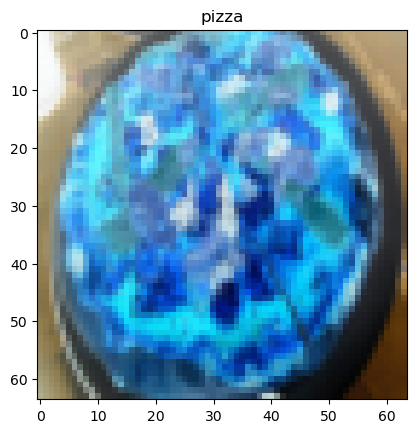

In [1683]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64,  64)),
    transforms.TrivialAugmentWide(5),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)

img, label = train_data[12]
plt.imshow(img.permute(1, 2, 0))
plt.title(train_data.classes[label])


In [1684]:
batch_size = 15
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

In [1685]:
img, label = next(iter(train_dataloader))
img.shape, label.shape

(torch.Size([15, 3, 64, 64]), torch.Size([15]))

In [1794]:
class AugmentCnn(nn.Module):
    def __init__(self, in_features, out_features, hidden=50, shape=None):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_features, hidden, kernel_size=1, padding=0, stride=1),
            nn.Conv2d(hidden, hidden, kernel_size=1, padding=0, stride=1),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        self.shape = round(shape/2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=0, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=0, stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=0, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=1, padding=0, stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=0, stride=1),
            nn.LeakyReLU(),
            nn.Conv2d(hidden, hidden, kernel_size=3, padding=0, stride=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=1, stride=1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden*54*54, out_features)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        try :
            x = self.classifier(x)
            return x
        except : 
            raise RuntimeError(f"the shape is {x.shape}")

In [1796]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_classes = len(train_data.classes)
model = AugmentCnn(in_features=3, out_features=n_classes, shape=img.shape[2]).to(device)

In [1798]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 30

In [1800]:
#from torchinfo import summary
#shape = img.shape[2]
#summary(model, input_size=[1, 3, shape, shape])

In [1802]:
from timeit import default_timer as timer
from sklearn.metrics import accuracy_score as acc

torch.manual_seed(42)
startTime = timer()
loss_train_curve = []
loss_test_curve = []

for epoch in (range(epochs)):
  loss_train = 0
  for (x, y) in (train_dataloader):
    model.train()
    x, y = x.to(device), y.to(device)
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    loss_train_curve.append(loss.cpu())
    loss_train += loss

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
      
  loss_train /= len(train_dataloader)

  model.eval()
  loss_test, test_acc = 0, 0
  with torch.inference_mode():
    for x_test, y_test in test_dataloader:
      x_test, y_test = x_test.to(device), y_test.to(device)
      test_pred = model(x_test)
      loss_ = loss_fn(test_pred, y_test)
      loss_test += loss_
      loss_test_curve.append(loss_.cpu())
      test_acc += acc(y_test.cpu(), test_pred.argmax(dim=1).cpu())

    loss_test /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  print(f"train loss : {loss_train:.4f} | test loss : {loss_test:.4f} | test acc : {test_acc*100}")

endTime = timer()
total_train_time = endTime - startTime
f"total time : {total_train_time:.4f} sec"

train loss : 1.1330 | test loss : 1.1072 | test acc : 25.33333333333333
train loss : 1.0377 | test loss : 1.0984 | test acc : 37.333333333333336
train loss : 0.9829 | test loss : 1.0430 | test acc : 44.00000000000001
train loss : 0.9155 | test loss : 1.0260 | test acc : 42.666666666666664
train loss : 0.8713 | test loss : 0.9975 | test acc : 58.666666666666664
train loss : 0.8591 | test loss : 1.1325 | test acc : 40.0
train loss : 0.9136 | test loss : 1.0398 | test acc : 50.66666666666667
train loss : 0.8104 | test loss : 1.0991 | test acc : 43.99999999999999
train loss : 0.8206 | test loss : 1.0285 | test acc : 45.33333333333334
train loss : 0.7389 | test loss : 1.1494 | test acc : 50.66666666666666
train loss : 0.7211 | test loss : 1.2900 | test acc : 41.333333333333336
train loss : 0.5826 | test loss : 1.6771 | test acc : 40.0
train loss : 0.6335 | test loss : 1.3903 | test acc : 42.666666666666664
train loss : 0.6265 | test loss : 1.2159 | test acc : 42.666666666666664
train loss :

'total time : 34.0615 sec'

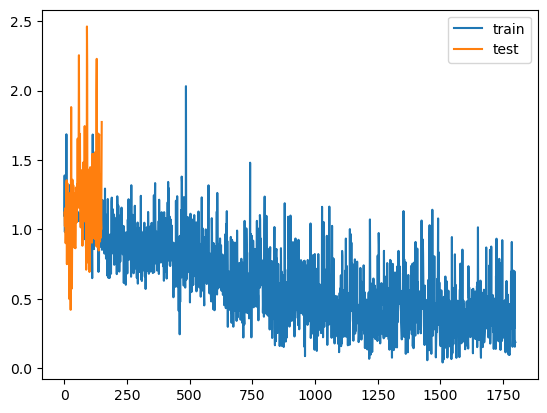

In [1804]:
import matplotlib.pyplot as plt
with torch.inference_mode():
    plt.plot(loss_train_curve, label="train")
    plt.plot(loss_test_curve, label="test")
    plt.legend()
plt.show()

In [1806]:
with open("data/pizza_dad.jpeg", 'wb') as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/04-pizza-dad.jpeg?raw=true")
    f.write(request.content)

In [1807]:
import torchvision
Test_Image = torchvision.io.read_image("data/pizza_dad.jpeg").type(torch.float32)/255 #why we divided by 255? because each pixel is between 0 to 255 so we devided it to scale it 0 to 1 and now it can be used

In [1808]:
Test_Image.dtype

torch.float32

In [1812]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

# Transform target image
custom_image_transformed = custom_image_transform(Test_Image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

(-0.5, 63.5, 63.5, -0.5)

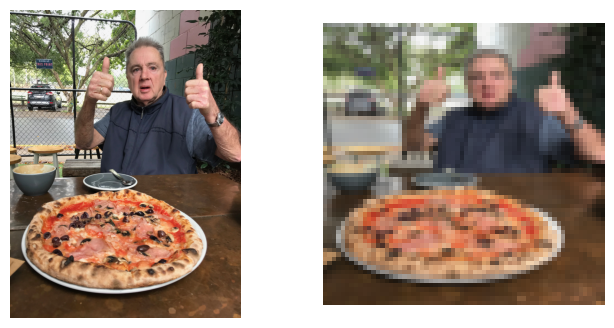

In [1814]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(Test_Image.permute(1, 2, 0))
plt.axis(False)
plt.subplot(1, 2, 2)
plt.imshow(custom_image_transformed.permute(1, 2, 0))
plt.axis(False)

In [1815]:
custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
custom_image_transformed.shape

torch.Size([1, 3, 64, 64])

In [1816]:
prediction = model(custom_image_transformed.to(device)).argmax(dim=1)
train_data.classes[prediction]

'pizza'

In [1820]:
with open("data/god_damnsushi.jpeg", 'wb') as f:
    request = requests.get("https://www.haushaltstipps.net/wp-content/uploads/sushi.jpg")
    f.write(request.content)

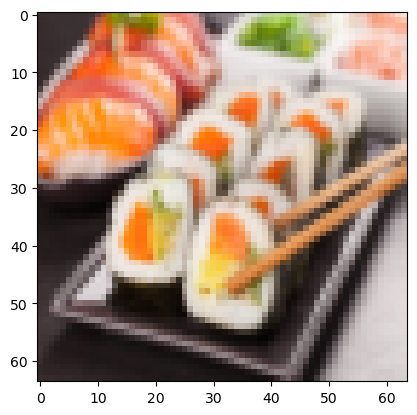

In [1822]:
Test_Image2 = torchvision.io.read_image("data/god_damnsushi.jpeg").type(torch.float32)/255
Test_Image2 = custom_image_transform(Test_Image2)
plt.imshow(Test_Image2.permute(1, 2, 0))

In [1762]:
Test_Image_tranformed2 = Test_Image2.unsqueeze(dim=0)
train_data.classes[model(Test_Image_tranformed2.to(device)).argmax(dim=1)] #alright it's just becuase model is a$$
#but well now we can predicted our own images

'steak'